# Load File


In [1]:
import os
import itertools

# ------------------------
# Folder and output paths
# ------------------------
bonafide_dir = "/kaggle/input/face-morph-dsp/FRLL_preprocessed/FRLL_preprocessed/bonafide"
output_file  = "/kaggle/working/FRLL_bonafide.txt"


# Only include selected codes (you can adjust if needed)
valid_codes = {"02","03","04","07","09", "08"}

# ------------------------
# List all JPG files
# ------------------------
bonafide_files = sorted([f for f in os.listdir(bonafide_dir) if f.lower().endswith(".jpg")])

print("Total bonafide images:", len(bonafide_files))
print("Sample files:", bonafide_files[:6])

# ------------------------
# Group by person (before '_') and filter by code (after '_')
# ------------------------
grouped = {}
for f in bonafide_files:
    if "_" in f:
        person_id, code = f.split("_")
        code = code.split(".")[0]  # remove .jpg
        if code in valid_codes:
            grouped.setdefault(person_id, []).append(f)

# ------------------------
# Generate all combinations within same person
# ------------------------
pairs = []
for person, files in grouped.items():
    if len(files) >= 2:
        for a, b in itertools.combinations(files, 2):
            pairs.append(f"{a} {b}")

# ------------------------
# Save pairs to file
# ------------------------
with open(output_file, "w") as f:
    f.write("\n".join(pairs))

print(f"✅ Done! Created bonafide_pairs.txt with {len(pairs)} pairs.")
print(f"📄 Saved to: {output_file}")


Total bonafide images: 612
Sample files: ['001_02.jpg', '001_03.jpg', '001_04.jpg', '001_07.jpg', '001_08.jpg', '001_09.jpg']
✅ Done! Created bonafide_pairs.txt with 1530 pairs.
📄 Saved to: /kaggle/working/FRLL_bonafide.txt


In [2]:
import os
import itertools

# Folder containing all images like 1-01.jpg, 1-02.jpg, etc.
bonafide_dir = "/kaggle/input/face-morph-dsp/FEI_preprocessed/FEI_preprocessed/bonafide"

# Output file
bonafide_pairs_file = "/kaggle/working/FEI_bonafide.txt"

# Only use these emotion/angle codes
valid_codes = {"04", "05", "06", "07", "11", "12", "13"}

# List only JPG files
bonafide_files = sorted([f for f in os.listdir(bonafide_dir) if f.lower().endswith(".jpg")])

# Group images by person number (before the "-")
grouped = {}
for f in bonafide_files:
    if "-" in f:
        person_id, code = f.split("-")
        code = code.split(".")[0]  # remove .jpg
        if code in valid_codes:
            grouped.setdefault(person_id, []).append(f)

# Create bonafide-bonafide pairs (within same person)
bonafide_pairs = []
for person, files in grouped.items():
    if len(files) >= 2:
        # make all unique pairs (e.g., 03-04, 03-05, etc.)
        for a, b in itertools.combinations(files, 2):
            bonafide_pairs.append(f"{a} {b}")

# Save to file
with open(bonafide_pairs_file, "w") as f:
    f.write("\n".join(bonafide_pairs))

print(f"✅ Done! Created bonafide_pairs.txt with {len(bonafide_pairs)} pairs.")
print(f"📄 Saved to: {bonafide_pairs_file}")


✅ Done! Created bonafide_pairs.txt with 4200 pairs.
📄 Saved to: /kaggle/working/FEI_bonafide.txt


In [3]:
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch

In [4]:

# ==================================================
# 1. LOAD BONAFIDE PAIRS FROM TXT FILE
# ==================================================
def load_bonafide_pairs(txt_path):
    pairs = []
    with open(txt_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 2:
                continue
            a, b = parts
            pairs.append((a, b, 0))  # label = 0
    return pairs


In [5]:

# ==================================================
# 2. FEI: BONAFIDE FROM TXT + ORIGINAL WORKING MORPH CODE
# ==================================================
def create_dmad_labels_fei(base_dir, txt_path):
    bona_dir  = os.path.join(base_dir, "bonafide")
    morph_dir = os.path.join(base_dir, "morphed")
    out_csv   = "/kaggle/working/FEI_dmad_labels.csv"

    records = []

    # ------------------ BONAFIDE FROM TEXT FILE ------------------
    bonafide_pairs = load_bonafide_pairs(txt_path)

    for a, b, lbl in bonafide_pairs:
        img1 = os.path.join(bona_dir, a)
        img2 = os.path.join(bona_dir, b)
        records.append([img1.replace("\\","/"),
                        img2.replace("\\","/"),
                        0])

    # ------------------ MORPH (ORIGINAL SUCCESSFUL CODE) ------------------
    morph_files = sorted(os.listdir(morph_dir))

    for f in morph_files:
        if not f.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        base = os.path.splitext(f)[0]     # e.g. 43-11_99-11_1
        id1  = base.split("_")[0]         # → 43-11

        bona_path = os.path.join(bona_dir, f"{id1}.jpg")
        morph_path = os.path.join(morph_dir, f)

        if os.path.exists(bona_path):  # ✔ ORIGINAL CHECK
            records.append([
                bona_path.replace("\\","/"),
                morph_path.replace("\\","/"),
                1
            ])

    df = pd.DataFrame(records, columns=["image1","image2","label"])
    df.to_csv(out_csv, index=False)

    print("\n🔥 FEI labeling complete →", out_csv)
    print("Bonafide:", (df.label==0).sum())
    print("Morph:", (df.label==1).sum())
    return df


In [6]:

# ==================================================
# 3. FRLL: BONAFIDE FROM TXT + ORIGINAL WORKING MORPH CODE
# ==================================================
def create_dmad_labels_frll(base_dir, txt_path):
    bona_dir  = os.path.join(base_dir, "bonafide")
    bona_dir2  = os.path.join(base_dir, "FRLL_bonafide")
    morph_dir = os.path.join(base_dir, "morphed")
    out_csv   = "/kaggle/working/FRLL_dmad_labels.csv"

    records = []

    # ------------------ BONAFIDE FROM TEXT FILE ------------------
    bonafide_pairs = load_bonafide_pairs(txt_path)

    for a, b, lbl in bonafide_pairs:
        img1 = os.path.join(bona_dir, a)
        img2 = os.path.join(bona_dir, b)
        records.append([img1.replace("\\","/"),
                        img2.replace("\\","/"),
                        0])

    # ------------------ MORPH (ORIGINAL SUCCESSFUL CODE) ------------------
    morph_files = sorted(os.listdir(morph_dir))

    for f in morph_files:
        if not f.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        base = os.path.splitext(f)[0]    # e.g. 173_03-142_03_1
        id1  = base.split("-")[0]        # → 173_03

        bona_path = os.path.join(bona_dir2, f"{id1}.jpg")
        morph_path = os.path.join(morph_dir, f)

        if os.path.exists(bona_path):  # ✔ ORIGINAL CHECK
            records.append([
                bona_path.replace("\\","/"),
                morph_path.replace("\\","/"),
                1
            ])

    df = pd.DataFrame(records, columns=["image1","image2","label"])
    df.to_csv(out_csv, index=False)

    print("\n🔥 FRLL labeling complete →", out_csv)
    print("Bonafide:", (df.label==0).sum())
    print("Morph:", (df.label==1).sum())
    return df


In [7]:
# ==================================================
# 4. RUN BOTH + COMBINE
# ==================================================
BASE_FEI  = "/kaggle/input/face-morph-dsp/FEI_preprocessed/FEI_preprocessed"
BASE_FRLL = "/kaggle/input/face-morph-dsp/FRLL_preprocessed/FRLL_preprocessed"

TXT_FEI   = "/kaggle/working/FEI_bonafide.txt"
TXT_FRLL  = "/kaggle/working/FRLL_bonafide.txt"

# Ensure output directory exists
os.makedirs("dataset_info", exist_ok=True)

fei_df  = create_dmad_labels_fei(BASE_FEI, TXT_FEI)
frll_df = create_dmad_labels_frll(BASE_FRLL, TXT_FRLL)

# Combine
combined = pd.concat([fei_df, frll_df], ignore_index=True)
combined.to_csv("/kaggle/working/combined_dmad_labels.csv", index=False)

print("\n🔥 Combined dataset created → dataset_info/combined_dmad_labels.csv")
print("Total pairs:", len(combined))



🔥 FEI labeling complete → /kaggle/working/FEI_dmad_labels.csv
Bonafide: 4200
Morph: 6000

🔥 FRLL labeling complete → /kaggle/working/FRLL_dmad_labels.csv
Bonafide: 1530
Morph: 2175

🔥 Combined dataset created → dataset_info/combined_dmad_labels.csv
Total pairs: 13905


# Start


In [8]:
import torch
from torch.utils.data import Dataset,DataLoader
from PIL import Image
import pandas as pd
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


class DMADDatasetByIndex(Dataset):
    def __init__(self, csv_path, img1_idx, img2_idx, label_idx, transform=None, has_header=True):
        # If your file has a header row like: img1,img2,label
        if has_header:
            self.df = pd.read_csv(csv_path)          # header = first row
        else:
            self.df = pd.read_csv(csv_path, header=None)

        print("CSV shape:", self.df.shape)
        print(self.df.head())  # debug

        self.img1_idx = img1_idx
        self.img2_idx = img2_idx
        self.label_idx = label_idx
        self.transform = transform

        # If labels are in a string column name, we will handle it in __getitem__

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Access by index
        img1_path = row.iloc[self.img1_idx]
        img2_path = row.iloc[self.img2_idx]
        raw_label = row.iloc[self.label_idx]

        # Handle label safely
        # Case 1: already numeric or string number like "0"/"1"
        try:
            label = int(raw_label)
        except ValueError:
            # Case 2: text label, map manually
            # Adjust mapping if your file uses different words
            if str(raw_label).lower() in ["bonafide", "genuine", "real"]:
                label = 0
            elif str(raw_label).lower() in ["morph", "attack", "fake"]:
                label = 1
            else:
                raise ValueError(f"Unexpected label value: {raw_label}")

        img1 = Image.open(img1_path).convert("RGB")
        img2 = Image.open(img2_path).convert("RGB")

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, label


In [9]:
import pandas as pd

df = pd.read_csv("/kaggle/working/FEI_dmad_labels.csv")
print(df.columns)
print(df.head())


Index(['image1', 'image2', 'label'], dtype='object')
                                              image1  \
0  /kaggle/input/face-morph-dsp/FEI_preprocessed/...   
1  /kaggle/input/face-morph-dsp/FEI_preprocessed/...   
2  /kaggle/input/face-morph-dsp/FEI_preprocessed/...   
3  /kaggle/input/face-morph-dsp/FEI_preprocessed/...   
4  /kaggle/input/face-morph-dsp/FEI_preprocessed/...   

                                              image2  label  
0  /kaggle/input/face-morph-dsp/FEI_preprocessed/...      0  
1  /kaggle/input/face-morph-dsp/FEI_preprocessed/...      0  
2  /kaggle/input/face-morph-dsp/FEI_preprocessed/...      0  
3  /kaggle/input/face-morph-dsp/FEI_preprocessed/...      0  
4  /kaggle/input/face-morph-dsp/FEI_preprocessed/...      0  


# 📌 2. Cosine Evaluation Function (Used for ALL Baselines)


In [10]:
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve

def evaluate_cosine_full(model, dataloader, device):
    model.eval()
    all_scores, all_labels = [], []

    with torch.no_grad():
        for img1, img2, labels in dataloader:
            img1 = img1.to(device)
            img2 = img2.to(device)

            labels = labels.cpu().numpy()

            emb1 = model(img1)
            emb2 = model(img2)

            cos = F.cosine_similarity(emb1, emb2, dim=1).cpu().numpy()

            all_scores.extend(list(cos))
            all_labels.extend(list(labels))

    all_scores = np.array(all_scores)
    all_labels = np.array(all_labels)

    # ------------------------------------------------------
    # 🔥 Best Threshold (sweeping)
    # ------------------------------------------------------
    best_acc = 0
    best_t = 0

    for t in np.linspace(-1, 1, 400):
        preds = (all_scores < t).astype(int)   # morph = 1
        acc = (preds == all_labels).mean()
        if acc > best_acc:
            best_acc = acc
            best_t = t

    # Apply the best threshold
    preds = (all_scores < best_t).astype(int)

    # ------------------------------------------------------
    # 🔥 Metrics
    # ------------------------------------------------------
    precision = precision_score(all_labels, preds, zero_division=0)
    recall = recall_score(all_labels, preds, zero_division=0)
    f1 = f1_score(all_labels, preds, zero_division=0)
    roc_auc = roc_auc_score(all_labels, 1- all_scores)

    # ------------------------------------------------------
    # 🔥 FAR / FRR / EER
    # ------------------------------------------------------
    fpr, tpr, thresholds = roc_curve(all_labels, -all_scores)  # invert for morph=1
    fnr = 1 - tpr
    eer_index = np.nanargmin(np.abs(fnr - fpr))
    eer = (fpr[eer_index] + fnr[eer_index]) / 2

    FAR = fpr[eer_index]
    FRR = fnr[eer_index]

    # ------------------------------------------------------
    # 🔥 Avg Cosines
    # ------------------------------------------------------
    bona_cos = all_scores[all_labels == 0].mean()
    morph_cos = all_scores[all_labels == 1].mean()

    # ------------------------------------------------------
    # 🔥 Print Final Results (same format as your FYP model)
    # ------------------------------------------------------
    print("\n==================== COSINE BASELINE RESULTS ====================")
    print(f"Best Threshold:          {best_t:.4f}")
    print(f"Accuracy:                {best_acc * 100:.2f}%")
    print(f"Precision:               {precision:.4f}")
    print(f"Recall:                  {recall:.4f}")
    print(f"F1-Score:                {f1:.4f}")
    print(f"ROC-AUC:                 {roc_auc:.4f}")
    print(f"FAR:                     {FAR:.4f}")
    print(f"FRR:                     {FRR:.4f}")
    print(f"EER:                     {eer:.4f}")
    print(f"Avg Bona Cosine:         {bona_cos:.4f}")
    print(f"Avg Morph Cosine:        {morph_cos:.4f}")
    print("===============================================================\n")

    return {
        "threshold": best_t,
        "accuracy": best_acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "far": FAR,
        "frr": FRR,
        "eer": eer,
        "bona_cos": bona_cos,
        "morph_cos": morph_cos,
        "all_scores": all_scores,
        "all_labels": all_labels
    }


# BASELINE 1: SIMPLE SIAMESE
1. Define a Simple Siamese Model

In [11]:
import torch.nn as nn
import torch

class SimpleSiamese(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        self.fc = nn.Linear(64, 128)

    def forward_once(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

    def forward(self, img1, img2):
        emb1 = self.forward_once(img1)
        emb2 = self.forward_once(img2)
        return emb1, emb2


2. Contrastive Loss

In [12]:
def contrastive_loss(emb1, emb2, label, margin=1.0):
    dist = F.pairwise_distance(emb1, emb2)
    loss = (1 - label) * dist.pow(2) + label * F.relu(margin - dist).pow(2)
    return loss.mean()


3. Train Siamese on FEI

In [13]:
import torch.nn.functional as F

def train_siamese(model, loader, device, epochs=5, margin=1.0):
    model.to(device)
    optim = torch.optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        total_correct = 0
        total_samples = 0

        for img1, img2, labels in loader:
            img1 = img1.to(device)
            img2 = img2.to(device)
            labels = labels.float().to(device)   # 0 = same/bona, 1 = morph/attack

            # --- forward ---
            emb1, emb2 = model(img1, img2)

            # contrastive loss
            dist = F.pairwise_distance(emb1, emb2)
            loss = (1 - labels) * dist.pow(2) + labels * F.relu(margin - dist).pow(2)
            loss = loss.mean()

            # --- backward ---
            optim.zero_grad()
            loss.backward()
            optim.step()

            # --- accumulate stats ---
            batch_size = labels.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size

            # 🌟 simple train accuracy (using a fixed threshold on distance)
            # predict morph(1) if distance > threshold, else bona(0)
            threshold = margin / 2.0
            preds = (dist > threshold).float()
            total_correct += (preds == labels).sum().item()

        avg_loss = total_loss / total_samples
        train_acc = total_correct / total_samples * 100.0

        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} | Train Acc (approx): {train_acc:.2f}%")


4. Testing Siamese Using Cosine (FRLL)

In [14]:
import torch.nn as nn

class SiameseEmbeddingWrapper(nn.Module):
    def __init__(self, siamese_model):
        super().__init__()
        self.siamese = siamese_model

    def forward(self, x):
        # x = batch of images
        # we only want the embedding for one branch
        return self.siamese.forward_once(x)


# BASELINE 2: ARCFACE + COSINE

In [17]:
!pip install facenet-pytorch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 45.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 73.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 99.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 66.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 3.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 6.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 15.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [18]:
from facenet_pytorch import InceptionResnetV1
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Create FaceNet embedder
class FaceNetEmbedder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

    def forward(self, x):
        x = x.to(device)
        return self.model(x)


# BASELINE 3: FACENET + COSINE

In [19]:
from facenet_pytorch import InceptionResnetV1

facenet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

class FaceNetEmbedder(nn.Module):
    def forward(self, x):
        return facenet(x)


  0%|          | 0.00/107M [00:00<?, ?B/s]

In [20]:
from torchvision import transforms
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),      # fixed size = no more mismatch
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

from torchvision import transforms
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),    # must match training
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [21]:
# 1. Load datasets
fei_train_dataset = DMADDatasetByIndex(
    csv_path="/kaggle/working/FEI_dmad_labels.csv",
    img1_idx=0,
    img2_idx=1,
    label_idx=2,
    transform=train_transform,
    has_header=True
)

frll_test_dataset = DMADDatasetByIndex(
    csv_path="/kaggle/working/FRLL_dmad_labels.csv",
    img1_idx=0,
    img2_idx=1,
    label_idx=2,
    transform=test_transform,
    has_header=True
)


fei_train_loader = DataLoader(fei_train_dataset, batch_size=16, shuffle=True)
frll_test_loader = DataLoader(frll_test_dataset, batch_size=16, shuffle=False)



CSV shape: (10200, 3)
                                              image1  \
0  /kaggle/input/face-morph-dsp/FEI_preprocessed/...   
1  /kaggle/input/face-morph-dsp/FEI_preprocessed/...   
2  /kaggle/input/face-morph-dsp/FEI_preprocessed/...   
3  /kaggle/input/face-morph-dsp/FEI_preprocessed/...   
4  /kaggle/input/face-morph-dsp/FEI_preprocessed/...   

                                              image2  label  
0  /kaggle/input/face-morph-dsp/FEI_preprocessed/...      0  
1  /kaggle/input/face-morph-dsp/FEI_preprocessed/...      0  
2  /kaggle/input/face-morph-dsp/FEI_preprocessed/...      0  
3  /kaggle/input/face-morph-dsp/FEI_preprocessed/...      0  
4  /kaggle/input/face-morph-dsp/FEI_preprocessed/...      0  
CSV shape: (3705, 3)
                                              image1  \
0  /kaggle/input/face-morph-dsp/FRLL_preprocessed...   
1  /kaggle/input/face-morph-dsp/FRLL_preprocessed...   
2  /kaggle/input/face-morph-dsp/FRLL_preprocessed...   
3  /kaggle/input/face-mo

In [22]:
simple_siamese = SimpleSiamese()
train_siamese(simple_siamese, fei_train_loader, device)

Epoch 1/5 - Loss: 0.3275 | Train Acc (approx): 46.63%
Epoch 2/5 - Loss: 0.3116 | Train Acc (approx): 47.72%
Epoch 3/5 - Loss: 0.3136 | Train Acc (approx): 46.54%
Epoch 4/5 - Loss: 0.3120 | Train Acc (approx): 46.98%
Epoch 5/5 - Loss: 0.3100 | Train Acc (approx): 47.28%


In [23]:
embed_model = SiameseEmbeddingWrapper(simple_siamese)

In [24]:
evaluate_cosine_full(embed_model, frll_test_loader, device)


==================== COSINE BASELINE RESULTS ====================
Best Threshold:          0.9749
Accuracy:                99.22%
Precision:               0.9936
Recall:                  0.9931
F1-Score:                0.9933
ROC-AUC:                 0.9990
FAR:                     0.0078
FRR:                     0.0083
EER:                     0.0081
Avg Bona Cosine:         0.9952
Avg Morph Cosine:        0.9331



{'threshold': 0.9749373433583959,
 'accuracy': 0.9921727395411606,
 'precision': 0.9935602575896965,
 'recall': 0.993103448275862,
 'f1': 0.9933318004138882,
 'roc_auc': 0.9989996243708211,
 'far': 0.00784313725490196,
 'frr': 0.008275862068965467,
 'eer': 0.008059499661933714,
 'bona_cos': 0.9951728,
 'morph_cos': 0.9331056,
 'all_scores': array([0.97637033, 0.99433726, 0.9995124 , ..., 0.9071592 , 0.9094472 ,
        0.8809947 ], dtype=float32),
 'all_labels': array([0, 0, 0, ..., 1, 1, 1])}

In [25]:
evaluate_cosine_full(FaceNetEmbedder(), frll_test_loader, device)



==================== COSINE BASELINE RESULTS ====================
Best Threshold:          0.7845
Accuracy:                82.97%
Precision:               0.8174
Recall:                  0.9140
F1-Score:                0.8630
ROC-AUC:                 0.8995
FAR:                     0.1876
FRR:                     0.1899
EER:                     0.1887
Avg Bona Cosine:         0.8263
Avg Morph Cosine:        0.6589



{'threshold': 0.7844611528822054,
 'accuracy': 0.829689608636977,
 'precision': 0.8174342105263158,
 'recall': 0.9140229885057471,
 'f1': 0.8630345126980681,
 'roc_auc': 0.8994691608444145,
 'far': 0.18758169934640523,
 'frr': 0.18988505747126438,
 'eer': 0.1887333784088348,
 'bona_cos': 0.82630235,
 'morph_cos': 0.6588956,
 'all_scores': array([0.726274  , 0.86228114, 0.9211072 , ..., 0.67393696, 0.67367387,
        0.6098199 ], dtype=float32),
 'all_labels': array([0, 0, 0, ..., 1, 1, 1])}

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(all_labels, all_scores, threshold):
    """
    Plot confusion matrix using best threshold
    """
    preds = (all_scores < threshold).astype(int)  # morph = 1

    cm = confusion_matrix(all_labels, preds)

    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Bona Fide", "Morph"],
        yticklabels=["Bona Fide", "Morph"]
    )

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix (Best Model)")
    plt.tight_layout()
    plt.show()


In [30]:
def plot_cosine_distribution(all_scores, all_labels):
    """
    Plot cosine similarity distribution for bona fide vs morph
    """
    bona_scores = all_scores[all_labels == 0]
    morph_scores = all_scores[all_labels == 1]

    plt.figure(figsize=(6,4))

    sns.kdeplot(bona_scores, label="Bona Fide", fill=True)
    sns.kdeplot(morph_scores, label="Morph", fill=True)

    plt.xlabel("Cosine Similarity")
    plt.ylabel("Density")
    plt.title("Cosine Similarity Distribution")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [33]:
import numpy as np
import matplotlib.pyplot as plt

def plot_embedding_distance_distribution(model, dataloader, device):
    model.eval()
    distances = []
    labels = []

    with torch.no_grad():
        for img1, img2, lbl in dataloader:
            img1 = img1.to(device)
            img2 = img2.to(device)

            emb1 = model(img1)
            emb2 = model(img2)

            # 🔥 L2 distance between embeddings
            dist = torch.norm(emb1 - emb2, dim=1)

            distances.extend(dist.cpu().numpy())
            labels.extend(lbl.cpu().numpy())

    distances = np.array(distances)
    labels = np.array(labels)

    bona_dist = distances[labels == 0]
    morph_dist = distances[labels == 1]

    plt.figure(figsize=(7,5))
    plt.hist(bona_dist, bins=40, alpha=0.7, label="Bona-fide", color="blue")
    plt.hist(morph_dist, bins=40, alpha=0.7, label="Morph", color="red")

    plt.xlabel("Embedding Distance (L2)")
    plt.ylabel("Frequency")
    plt.title("FRLL Embedding Distance Distribution")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


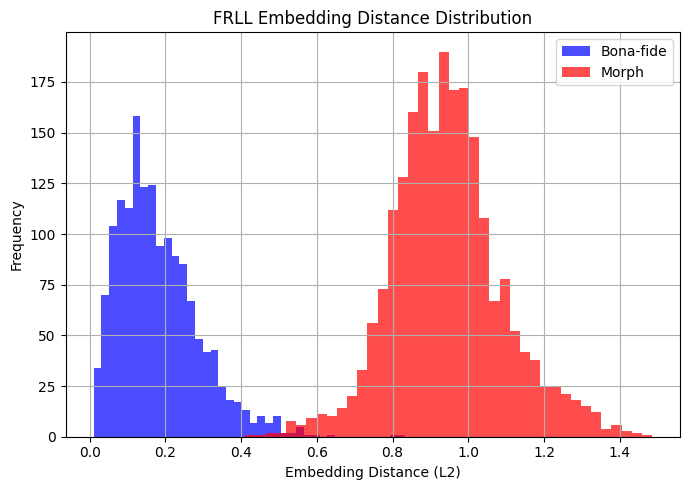

In [34]:
plot_embedding_distance_distribution(embed_model, frll_test_loader, device)



==================== COSINE BASELINE RESULTS ====================
Best Threshold:          0.9749
Accuracy:                99.22%
Precision:               0.9936
Recall:                  0.9931
F1-Score:                0.9933
ROC-AUC:                 0.9990
FAR:                     0.0078
FRR:                     0.0083
EER:                     0.0081
Avg Bona Cosine:         0.9952
Avg Morph Cosine:        0.9331



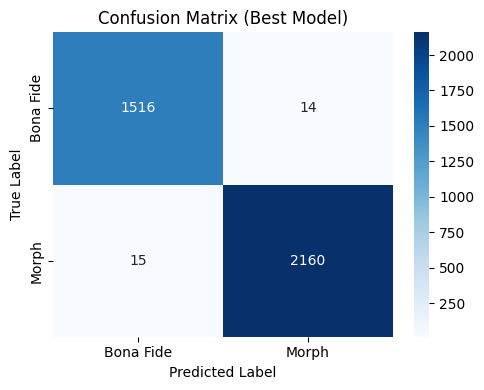

In [29]:
result= evaluate_cosine_full(embed_model, frll_test_loader, device)

all_labels = result["all_labels"]
all_scores = result["all_scores"]
best_t     = result["threshold"]

plot_confusion_matrix(all_labels, all_scores, best_t)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


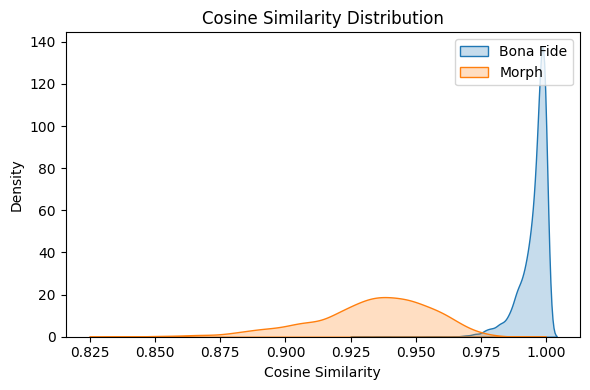

In [31]:
plot_cosine_distribution(all_scores, all_labels)

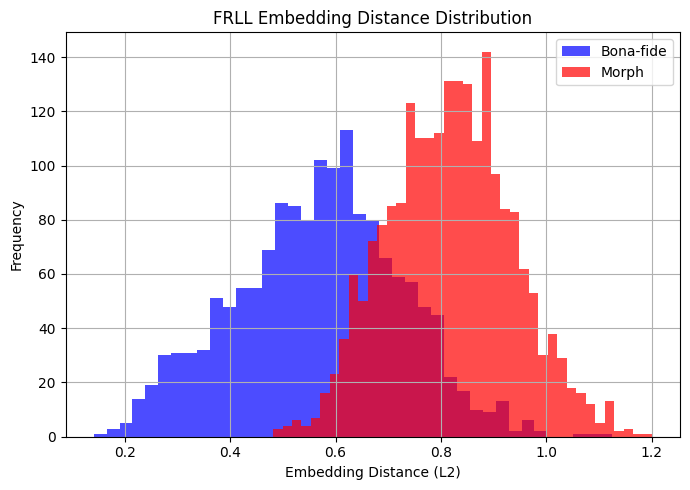

In [35]:
plot_embedding_distance_distribution(FaceNetEmbedder(), frll_test_loader, device)



==================== COSINE BASELINE RESULTS ====================
Best Threshold:          0.7845
Accuracy:                82.97%
Precision:               0.8174
Recall:                  0.9140
F1-Score:                0.8630
ROC-AUC:                 0.8995
FAR:                     0.1876
FRR:                     0.1899
EER:                     0.1887
Avg Bona Cosine:         0.8263
Avg Morph Cosine:        0.6589



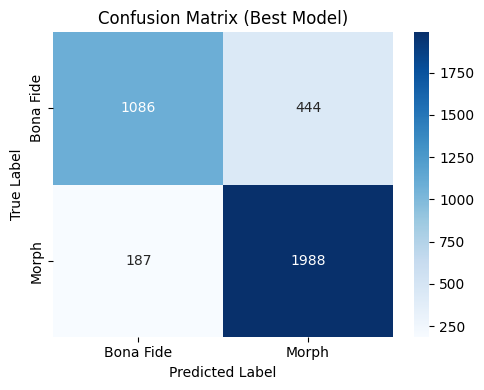

In [32]:
result1= evaluate_cosine_full(FaceNetEmbedder(), frll_test_loader, device)

all_labels = result1["all_labels"]
all_scores = result1["all_scores"]
best_t     = result1["threshold"]

plot_confusion_matrix(all_labels, all_scores, best_t)
